In [1]:
import matplotlib
import poloniex
import datetime

# import holoviews as hv
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import plotly
plotly.offline.init_notebook_mode()
from plotly.offline import iplot 
import plotly.graph_objs as go
import backtrader
import pandas as pd
# hv.notebook_extension('matplotlib')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Let's Start by checking your balances. You need to have your keys stored somewhere the bitfinex client can find.

Let's Download some historic series:

In [ ]:
# wget.download('http://api.bitcoincharts.com/v1/csv/bitfinexUSD.csv.gz','bitfinexUSD.csv.gz')

In [5]:
bitcoin = pd.read_csv('http://api.bitcoincharts.com/v1/csv/bitfinexUSD.csv.gz', compression='gzip')

In [8]:
bitcoin.columns = ['datetime', 'price', 'volume']
bitcoin['datetime'] = pd.to_datetime(bitcoin.datetime, unit='s')
bitcoin.set_index(['datetime'], inplace=True)
bitcoin.head()

datetime  price     volume
0 1970-01-01 00:00:01.364767669   93.3  80.628518
1 1970-01-01 00:00:01.364767693  100.0  20.000000
2 1970-01-01 00:00:01.364767694  100.0   1.000000
3 1970-01-01 00:00:01.364767696  100.0   5.900000
4 1970-01-01 00:00:01.364767699  100.0  29.833879

In [3]:
end = datetime.datetime.now()
start = end - datetime.timedelta(days=364)
ether = poloniex.get_ohlc('USDT_ETH',start, end)

In [4]:
print(ether.info())
ether.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 104832 entries, 2016-07-24 21:30:00 to 2017-07-23 21:25:00
Data columns (total 7 columns):
close              104832 non-null float64
high               104832 non-null float64
low                104832 non-null float64
open               104832 non-null float64
quoteVolume        104832 non-null float64
volume             104832 non-null float64
weightedAverage    104832 non-null float64
dtypes: float64(7)
memory usage: 6.4 MB
None


close           high            low           open  \
count  104832.000000  104832.000000  104832.000000  104832.000000   
mean       62.548841      62.755770      62.331287      62.548394   
std        92.742047      93.082558      92.377866      92.742788   
min         5.883966       5.964728       5.854031       5.900000   
25%        10.773000      10.789355      10.760000      10.771000   
50%        12.690242      12.700000      12.680000      12.690440   
75%        53.100000      53.290000      53.000000      53.100000   
max       405.000000     408.128700     395.800000     405.000000   

         quoteVolume        volume  weightedAverage  
count  104832.000000  1.048320e+05    104832.000000  
mean      164.412202  1.910313e+04        62.542186  
std       451.851667  6.691182e+04        92.727330  
min         0.000000  0.000000e+00         5.900298  
25%         0.307249  3.376053e+00        10.771000  
50%        13.396043  2.309477e+02        12.690177  
75%       128.897132  7.736385e+03        53.094674  
max     13335.125868  2.630736e+06       399.911100

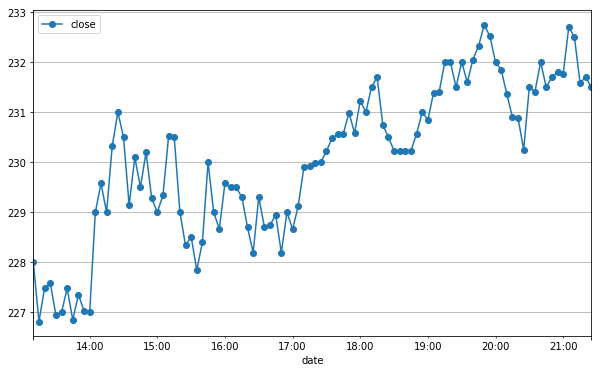

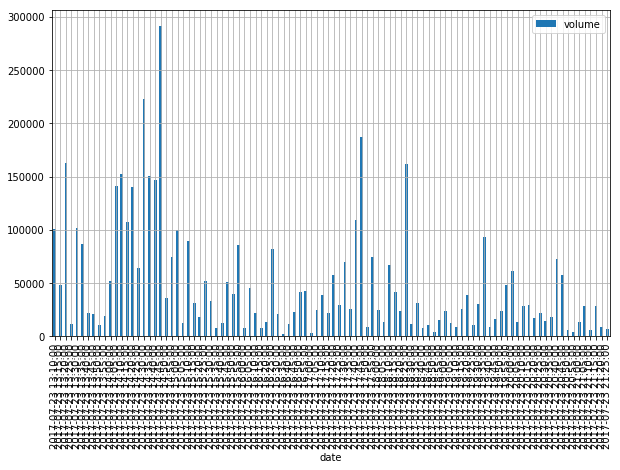

In [5]:
ether[-100:].plot(y='close',figsize=(10,6), style='-o', grid=True);
ether[-100:].plot(y='volume', kind='bar',figsize=(10,6), grid=True);

In [6]:
trace = go.Candlestick(x=ether.index,
                       open=ether.open,
                       high=ether.high,
                       low=ether.low,
                       close=ether.close)
data = [trace]
iplot(data, filename='simple_candlestick')


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


# Creating a strategy

From now on we are going to use the [backtrader](https://www.backtrader.com/docu/index.html) library to implent algirithmic strategies to trade Ether. 

In [61]:
import backtrader as bt
import backtrader.indicators as btind
import backtrader.analyzers as btanalyzers

In [8]:
def run_test():
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    res = cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    return res

In [9]:
class SMA_CrossOver(backtrader.Strategy):

    params = (('fast', 12), ('slow', 26))

    def __init__(self):
        self.rsi = btind.RSI()
        sma_fast = btind.SMA(period=self.p.fast)
        sma_slow = btind.SMA(period=self.p.slow)

        self.buysig = btind.CrossOver(sma_fast, sma_slow)

    def next(self):
        if self.position.size:
#             if (self.buysig < 0):
#                 self.sell()

#       elif (self.buysig > 0):
#                 self.buy()
            if (self.rsi<=50):
                self.sell()

        elif (self.rsi>=60):
            self.buy()
            
class Aroon(backtrader.Strategy):
    params = (('period',70),)
    def __init__(self):
        self.a_up = btind.AroonUp(period=self.p.period)
        self.a_down = btind.AroonDown(period=self.p.period)
    def next(self):
        if self.position.size:
            if self.a_down >= 95:
                self.sell()
        elif self.a_up >=97:
            self.buy()

In [80]:
class MarcosStrat(backtrader.Strategy):
    def __init__(self):
        self.delta = 10
        self.price_in = None
        self.price_out = 100000
        self.trailing = 0.5
        self.target = 10000000
        self.order = None
        print(self.position.size)
        
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enougth cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
    def next(self):
        if self.order:
            print(self.order)
            return
        self.price_out = self.data.close[0] if self.price_out is None else self.price_out
        if self.position.size:
            #self.price_in = self.data.close[0] if self.price_in is None else self.price_in
            
            if self.data.close[0] - self.price_in >= self.delta:
#                 print("Sell. Price: {}, price_out: {}, price_in:{}".format(self.data.close[0],self.price_out, self.price_in))
                #self.target =  self.data.close-self.trailing if self.data.close > self.target else self.target 
                #if self.data.close <= self.target:
                self.order = self.sell()
                print("Position:", self.position.size)
                self.price_out = self.data.close[0]
        
        if self.data.close[0] - self.price_out <= -self.delta:

#             print("Buying: {}. Price: {}, price_out: {}, price_in:{}".format(self.position.size,self.data.close[0],self.price_out, self.price_in))

            #self.target =  self.data.close+self.trailing if self.data.close < self.target else self.target 
            #if self.data.close >= self.target:
            self.order = self.buy()
            self.price_in = self.data.close[0]

In [81]:
cerebro = backtrader.Cerebro()
cerebro.broker.setcash(100000.0)
data2 = backtrader.feeds.PandasData(dataname=ether[:], datetime=None)
cerebro.adddata(data2)
cerebro.broker.setcommission(commission=0.001)
cerebro.addsizer(backtrader.sizers.FixedSize, stake=10)
# cerebro.addstrategy(SMA_CrossOver)
cerebro.addstrategy(MarcosStrat)
#cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe')
res = run_test()
#print('Sharpe Ratio:', res[0].analyzers.mysharpe.get_analysis())

Starting Portfolio Value: 100000.00
0
2016-07-24, BUY EXECUTED, Price: 12.96, Cost: 129.60, Comm 0.13
2016-07-24, BUY EXECUTED, Price: 12.99, Cost: 129.89, Comm 0.13
2016-07-24, BUY EXECUTED, Price: 12.98, Cost: 129.80, Comm 0.13
2016-07-24, BUY EXECUTED, Price: 12.86, Cost: 128.60, Comm 0.13
2016-07-24, BUY EXECUTED, Price: 12.86, Cost: 128.60, Comm 0.13
2016-07-24, BUY EXECUTED, Price: 12.81, Cost: 128.12, Comm 0.13
2016-07-24, BUY EXECUTED, Price: 12.95, Cost: 129.50, Comm 0.13
2016-07-24, BUY EXECUTED, Price: 12.95, Cost: 129.49, Comm 0.13
2016-07-24, BUY EXECUTED, Price: 12.95, Cost: 129.49, Comm 0.13
2016-07-24, BUY EXECUTED, Price: 12.95, Cost: 129.49, Comm 0.13
2016-07-24, BUY EXECUTED, Price: 12.81, Cost: 128.12, Comm 0.13
2016-07-24, BUY EXECUTED, Price: 12.81, Cost: 128.11, Comm 0.13
2016-07-24, BUY EXECUTED, Price: 12.81, Cost: 128.11, Comm 0.13
2016-07-24, BUY EXECUTED, Price: 12.81, Cost: 128.11, Comm 0.13
2016-07-24, BUY EXECUTED, Price: 12.81, Cost: 128.11, Comm 0.13
20

2016-07-25, BUY EXECUTED, Price: 13.59, Cost: 135.85, Comm 0.14
2016-07-25, BUY EXECUTED, Price: 13.59, Cost: 135.85, Comm 0.14
2016-07-25, BUY EXECUTED, Price: 13.58, Cost: 135.79, Comm 0.14
2016-07-25, BUY EXECUTED, Price: 13.53, Cost: 135.30, Comm 0.14
2016-07-25, BUY EXECUTED, Price: 13.50, Cost: 135.00, Comm 0.14
2016-07-25, BUY EXECUTED, Price: 13.50, Cost: 135.00, Comm 0.14
2016-07-25, BUY EXECUTED, Price: 13.58, Cost: 135.76, Comm 0.14
2016-07-25, BUY EXECUTED, Price: 13.40, Cost: 134.00, Comm 0.13
2016-07-25, BUY EXECUTED, Price: 13.32, Cost: 133.24, Comm 0.13
2016-07-25, BUY EXECUTED, Price: 13.21, Cost: 132.10, Comm 0.13
2016-07-25, BUY EXECUTED, Price: 13.21, Cost: 132.10, Comm 0.13
2016-07-25, BUY EXECUTED, Price: 13.20, Cost: 132.00, Comm 0.13
2016-07-25, BUY EXECUTED, Price: 13.28, Cost: 132.80, Comm 0.13
2016-07-25, BUY EXECUTED, Price: 13.33, Cost: 133.30, Comm 0.13
2016-07-25, BUY EXECUTED, Price: 13.30, Cost: 133.00, Comm 0.13
2016-07-25, BUY EXECUTED, Price: 13.24, 

2016-07-27, BUY EXECUTED, Price: 12.39, Cost: 123.91, Comm 0.12
2016-07-27, BUY EXECUTED, Price: 12.39, Cost: 123.91, Comm 0.12
2016-07-27, BUY EXECUTED, Price: 12.28, Cost: 122.83, Comm 0.12
2016-07-27, BUY EXECUTED, Price: 12.28, Cost: 122.83, Comm 0.12
2016-07-27, BUY EXECUTED, Price: 12.28, Cost: 122.83, Comm 0.12
2016-07-27, BUY EXECUTED, Price: 12.28, Cost: 122.83, Comm 0.12
2016-07-27, BUY EXECUTED, Price: 12.20, Cost: 122.00, Comm 0.12
2016-07-27, BUY EXECUTED, Price: 12.20, Cost: 122.00, Comm 0.12
2016-07-27, BUY EXECUTED, Price: 12.20, Cost: 122.00, Comm 0.12
2016-07-27, BUY EXECUTED, Price: 12.20, Cost: 122.04, Comm 0.12
2016-07-27, BUY EXECUTED, Price: 12.21, Cost: 122.10, Comm 0.12
2016-07-27, BUY EXECUTED, Price: 12.30, Cost: 123.00, Comm 0.12
2016-07-27, BUY EXECUTED, Price: 12.35, Cost: 123.50, Comm 0.12
2016-07-27, BUY EXECUTED, Price: 12.35, Cost: 123.50, Comm 0.12
2016-07-27, BUY EXECUTED, Price: 12.44, Cost: 124.40, Comm 0.12
2016-07-27, BUY EXECUTED, Price: 12.45, 

2016-07-30, Order Canceled/Margin/Rejected
2016-07-30, Order Canceled/Margin/Rejected
2016-07-30, Order Canceled/Margin/Rejected
2016-07-30, Order Canceled/Margin/Rejected
2016-07-30, Order Canceled/Margin/Rejected
2016-07-30, Order Canceled/Margin/Rejected
2016-07-30, Order Canceled/Margin/Rejected
2016-07-30, Order Canceled/Margin/Rejected
2016-07-30, Order Canceled/Margin/Rejected
2016-07-30, Order Canceled/Margin/Rejected
2016-07-30, Order Canceled/Margin/Rejected
2016-07-30, Order Canceled/Margin/Rejected
2016-07-30, Order Canceled/Margin/Rejected
2016-07-30, Order Canceled/Margin/Rejected
2016-07-30, Order Canceled/Margin/Rejected
2016-07-30, Order Canceled/Margin/Rejected
2016-07-30, Order Canceled/Margin/Rejected
2016-07-30, Order Canceled/Margin/Rejected
2016-07-30, Order Canceled/Margin/Rejected
2016-07-30, Order Canceled/Margin/Rejected
2016-07-30, Order Canceled/Margin/Rejected
2016-07-30, Order Canceled/Margin/Rejected
2016-07-30, Order Canceled/Margin/Rejected
2016-07-30,

2016-08-03, Order Canceled/Margin/Rejected
2016-08-03, Order Canceled/Margin/Rejected
2016-08-03, Order Canceled/Margin/Rejected
2016-08-03, Order Canceled/Margin/Rejected
2016-08-03, Order Canceled/Margin/Rejected
2016-08-03, Order Canceled/Margin/Rejected
2016-08-03, Order Canceled/Margin/Rejected
2016-08-03, Order Canceled/Margin/Rejected
2016-08-03, Order Canceled/Margin/Rejected
2016-08-03, Order Canceled/Margin/Rejected
2016-08-03, Order Canceled/Margin/Rejected
2016-08-03, Order Canceled/Margin/Rejected
2016-08-03, Order Canceled/Margin/Rejected
2016-08-03, Order Canceled/Margin/Rejected
2016-08-03, Order Canceled/Margin/Rejected
2016-08-03, Order Canceled/Margin/Rejected
2016-08-03, Order Canceled/Margin/Rejected
2016-08-03, Order Canceled/Margin/Rejected
2016-08-03, Order Canceled/Margin/Rejected
2016-08-03, Order Canceled/Margin/Rejected
2016-08-03, Order Canceled/Margin/Rejected
2016-08-03, Order Canceled/Margin/Rejected
2016-08-03, Order Canceled/Margin/Rejected
2016-08-03,

2016-08-06, Order Canceled/Margin/Rejected
2016-08-06, Order Canceled/Margin/Rejected
2016-08-06, Order Canceled/Margin/Rejected
2016-08-06, Order Canceled/Margin/Rejected
2016-08-06, Order Canceled/Margin/Rejected
2016-08-06, Order Canceled/Margin/Rejected
2016-08-06, Order Canceled/Margin/Rejected
2016-08-06, Order Canceled/Margin/Rejected
2016-08-06, Order Canceled/Margin/Rejected
2016-08-06, Order Canceled/Margin/Rejected
2016-08-06, Order Canceled/Margin/Rejected
2016-08-06, Order Canceled/Margin/Rejected
2016-08-06, Order Canceled/Margin/Rejected
2016-08-06, Order Canceled/Margin/Rejected
2016-08-06, Order Canceled/Margin/Rejected
2016-08-06, Order Canceled/Margin/Rejected
2016-08-06, Order Canceled/Margin/Rejected
2016-08-06, Order Canceled/Margin/Rejected
2016-08-06, Order Canceled/Margin/Rejected
2016-08-06, Order Canceled/Margin/Rejected
2016-08-06, Order Canceled/Margin/Rejected
2016-08-06, Order Canceled/Margin/Rejected
2016-08-06, Order Canceled/Margin/Rejected
2016-08-06,

2016-08-10, Order Canceled/Margin/Rejected
2016-08-10, Order Canceled/Margin/Rejected
2016-08-10, Order Canceled/Margin/Rejected
2016-08-10, Order Canceled/Margin/Rejected
2016-08-10, Order Canceled/Margin/Rejected
2016-08-10, Order Canceled/Margin/Rejected
2016-08-10, Order Canceled/Margin/Rejected
2016-08-10, Order Canceled/Margin/Rejected
2016-08-10, Order Canceled/Margin/Rejected
2016-08-10, Order Canceled/Margin/Rejected
2016-08-10, Order Canceled/Margin/Rejected
2016-08-10, Order Canceled/Margin/Rejected
2016-08-10, Order Canceled/Margin/Rejected
2016-08-10, Order Canceled/Margin/Rejected
2016-08-10, Order Canceled/Margin/Rejected
2016-08-10, Order Canceled/Margin/Rejected
2016-08-10, Order Canceled/Margin/Rejected
2016-08-10, Order Canceled/Margin/Rejected
2016-08-10, Order Canceled/Margin/Rejected
2016-08-10, Order Canceled/Margin/Rejected
2016-08-10, Order Canceled/Margin/Rejected
2016-08-10, Order Canceled/Margin/Rejected
2016-08-10, Order Canceled/Margin/Rejected
2016-08-10,

2016-08-13, Order Canceled/Margin/Rejected
2016-08-13, Order Canceled/Margin/Rejected
2016-08-13, Order Canceled/Margin/Rejected
2016-08-13, Order Canceled/Margin/Rejected
2016-08-13, Order Canceled/Margin/Rejected
2016-08-13, Order Canceled/Margin/Rejected
2016-08-13, Order Canceled/Margin/Rejected
2016-08-13, Order Canceled/Margin/Rejected
2016-08-13, Order Canceled/Margin/Rejected
2016-08-13, Order Canceled/Margin/Rejected
2016-08-13, Order Canceled/Margin/Rejected
2016-08-13, Order Canceled/Margin/Rejected
2016-08-13, Order Canceled/Margin/Rejected
2016-08-13, Order Canceled/Margin/Rejected
2016-08-13, Order Canceled/Margin/Rejected
2016-08-13, Order Canceled/Margin/Rejected
2016-08-13, Order Canceled/Margin/Rejected
2016-08-13, Order Canceled/Margin/Rejected
2016-08-13, Order Canceled/Margin/Rejected
2016-08-13, Order Canceled/Margin/Rejected
2016-08-13, Order Canceled/Margin/Rejected
2016-08-13, Order Canceled/Margin/Rejected
2016-08-13, Order Canceled/Margin/Rejected
2016-08-13,

2016-08-17, Order Canceled/Margin/Rejected
2016-08-17, Order Canceled/Margin/Rejected
2016-08-17, Order Canceled/Margin/Rejected
2016-08-17, Order Canceled/Margin/Rejected
2016-08-17, Order Canceled/Margin/Rejected
2016-08-17, Order Canceled/Margin/Rejected
2016-08-17, Order Canceled/Margin/Rejected
2016-08-17, Order Canceled/Margin/Rejected
2016-08-17, Order Canceled/Margin/Rejected
2016-08-17, Order Canceled/Margin/Rejected
2016-08-17, Order Canceled/Margin/Rejected
2016-08-17, Order Canceled/Margin/Rejected
2016-08-17, Order Canceled/Margin/Rejected
2016-08-17, Order Canceled/Margin/Rejected
2016-08-17, Order Canceled/Margin/Rejected
2016-08-17, Order Canceled/Margin/Rejected
2016-08-17, Order Canceled/Margin/Rejected
2016-08-17, Order Canceled/Margin/Rejected
2016-08-17, Order Canceled/Margin/Rejected
2016-08-17, Order Canceled/Margin/Rejected
2016-08-17, Order Canceled/Margin/Rejected
2016-08-17, Order Canceled/Margin/Rejected
2016-08-17, Order Canceled/Margin/Rejected
2016-08-17,

2016-08-20, Order Canceled/Margin/Rejected
2016-08-20, Order Canceled/Margin/Rejected
2016-08-20, Order Canceled/Margin/Rejected
2016-08-20, Order Canceled/Margin/Rejected
2016-08-20, Order Canceled/Margin/Rejected
2016-08-20, Order Canceled/Margin/Rejected
2016-08-20, Order Canceled/Margin/Rejected
2016-08-20, Order Canceled/Margin/Rejected
2016-08-20, Order Canceled/Margin/Rejected
2016-08-20, Order Canceled/Margin/Rejected
2016-08-20, Order Canceled/Margin/Rejected
2016-08-20, Order Canceled/Margin/Rejected
2016-08-20, Order Canceled/Margin/Rejected
2016-08-20, Order Canceled/Margin/Rejected
2016-08-20, Order Canceled/Margin/Rejected
2016-08-20, Order Canceled/Margin/Rejected
2016-08-20, Order Canceled/Margin/Rejected
2016-08-20, Order Canceled/Margin/Rejected
2016-08-20, Order Canceled/Margin/Rejected
2016-08-20, Order Canceled/Margin/Rejected
2016-08-20, Order Canceled/Margin/Rejected
2016-08-20, Order Canceled/Margin/Rejected
2016-08-20, Order Canceled/Margin/Rejected
2016-08-20,

2016-08-23, Order Canceled/Margin/Rejected
2016-08-23, Order Canceled/Margin/Rejected
2016-08-23, Order Canceled/Margin/Rejected
2016-08-23, Order Canceled/Margin/Rejected
2016-08-23, Order Canceled/Margin/Rejected
2016-08-23, Order Canceled/Margin/Rejected
2016-08-23, Order Canceled/Margin/Rejected
2016-08-23, Order Canceled/Margin/Rejected
2016-08-23, Order Canceled/Margin/Rejected
2016-08-23, Order Canceled/Margin/Rejected
2016-08-23, Order Canceled/Margin/Rejected
2016-08-23, Order Canceled/Margin/Rejected
2016-08-24, Order Canceled/Margin/Rejected
2016-08-24, Order Canceled/Margin/Rejected
2016-08-24, Order Canceled/Margin/Rejected
2016-08-24, Order Canceled/Margin/Rejected
2016-08-24, Order Canceled/Margin/Rejected
2016-08-24, Order Canceled/Margin/Rejected
2016-08-24, Order Canceled/Margin/Rejected
2016-08-24, Order Canceled/Margin/Rejected
2016-08-24, Order Canceled/Margin/Rejected
2016-08-24, Order Canceled/Margin/Rejected
2016-08-24, Order Canceled/Margin/Rejected
2016-08-24,

2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27, Order Canceled/Margin/Rejected
2016-08-27,

2016-08-30, Order Canceled/Margin/Rejected
2016-08-30, Order Canceled/Margin/Rejected
2016-08-31, Order Canceled/Margin/Rejected
2016-08-31, Order Canceled/Margin/Rejected
2016-08-31, Order Canceled/Margin/Rejected
2016-08-31, Order Canceled/Margin/Rejected
2016-08-31, Order Canceled/Margin/Rejected
2016-08-31, Order Canceled/Margin/Rejected
2016-08-31, Order Canceled/Margin/Rejected
2016-08-31, Order Canceled/Margin/Rejected
2016-08-31, Order Canceled/Margin/Rejected
2016-08-31, Order Canceled/Margin/Rejected
2016-08-31, Order Canceled/Margin/Rejected
2016-08-31, Order Canceled/Margin/Rejected
2016-08-31, Order Canceled/Margin/Rejected
2016-08-31, Order Canceled/Margin/Rejected
2016-08-31, Order Canceled/Margin/Rejected
2016-08-31, Order Canceled/Margin/Rejected
2016-08-31, Order Canceled/Margin/Rejected
2016-08-31, Order Canceled/Margin/Rejected
2016-08-31, Order Canceled/Margin/Rejected
2016-08-31, Order Canceled/Margin/Rejected
2016-08-31, Order Canceled/Margin/Rejected
2016-08-31,

2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03,

2016-09-06, Order Canceled/Margin/Rejected
2016-09-06, Order Canceled/Margin/Rejected
2016-09-06, Order Canceled/Margin/Rejected
2016-09-06, Order Canceled/Margin/Rejected
2016-09-06, Order Canceled/Margin/Rejected
2016-09-06, Order Canceled/Margin/Rejected
2016-09-06, Order Canceled/Margin/Rejected
2016-09-06, Order Canceled/Margin/Rejected
2016-09-06, Order Canceled/Margin/Rejected
2016-09-06, Order Canceled/Margin/Rejected
2016-09-07, Order Canceled/Margin/Rejected
2016-09-07, Order Canceled/Margin/Rejected
2016-09-07, Order Canceled/Margin/Rejected
2016-09-07, Order Canceled/Margin/Rejected
2016-09-07, Order Canceled/Margin/Rejected
2016-09-07, Order Canceled/Margin/Rejected
2016-09-07, Order Canceled/Margin/Rejected
2016-09-07, Order Canceled/Margin/Rejected
2016-09-07, Order Canceled/Margin/Rejected
2016-09-07, Order Canceled/Margin/Rejected
2016-09-07, Order Canceled/Margin/Rejected
2016-09-07, Order Canceled/Margin/Rejected
2016-09-07, Order Canceled/Margin/Rejected
2016-09-07,

2016-09-10, Order Canceled/Margin/Rejected
2016-09-10, Order Canceled/Margin/Rejected
2016-09-10, Order Canceled/Margin/Rejected
2016-09-10, Order Canceled/Margin/Rejected
2016-09-10, Order Canceled/Margin/Rejected
2016-09-10, Order Canceled/Margin/Rejected
2016-09-10, Order Canceled/Margin/Rejected
2016-09-10, Order Canceled/Margin/Rejected
2016-09-10, Order Canceled/Margin/Rejected
2016-09-10, Order Canceled/Margin/Rejected
2016-09-10, Order Canceled/Margin/Rejected
2016-09-10, Order Canceled/Margin/Rejected
2016-09-10, Order Canceled/Margin/Rejected
2016-09-10, Order Canceled/Margin/Rejected
2016-09-10, Order Canceled/Margin/Rejected
2016-09-10, Order Canceled/Margin/Rejected
2016-09-10, Order Canceled/Margin/Rejected
2016-09-10, Order Canceled/Margin/Rejected
2016-09-10, Order Canceled/Margin/Rejected
2016-09-10, Order Canceled/Margin/Rejected
2016-09-10, Order Canceled/Margin/Rejected
2016-09-10, Order Canceled/Margin/Rejected
2016-09-10, Order Canceled/Margin/Rejected
2016-09-10,

2016-09-13, Order Canceled/Margin/Rejected
2016-09-13, Order Canceled/Margin/Rejected
2016-09-13, Order Canceled/Margin/Rejected
2016-09-13, Order Canceled/Margin/Rejected
2016-09-13, Order Canceled/Margin/Rejected
2016-09-13, Order Canceled/Margin/Rejected
2016-09-13, Order Canceled/Margin/Rejected
2016-09-13, Order Canceled/Margin/Rejected
2016-09-13, Order Canceled/Margin/Rejected
2016-09-13, Order Canceled/Margin/Rejected
2016-09-13, Order Canceled/Margin/Rejected
2016-09-13, Order Canceled/Margin/Rejected
2016-09-13, Order Canceled/Margin/Rejected
2016-09-13, Order Canceled/Margin/Rejected
2016-09-13, Order Canceled/Margin/Rejected
2016-09-13, Order Canceled/Margin/Rejected
2016-09-13, Order Canceled/Margin/Rejected
2016-09-13, Order Canceled/Margin/Rejected
2016-09-13, Order Canceled/Margin/Rejected
2016-09-13, Order Canceled/Margin/Rejected
2016-09-13, Order Canceled/Margin/Rejected
2016-09-13, Order Canceled/Margin/Rejected
2016-09-13, Order Canceled/Margin/Rejected
2016-09-13,

2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17, Order Canceled/Margin/Rejected
2016-09-17,

2016-09-20, Order Canceled/Margin/Rejected
2016-09-20, Order Canceled/Margin/Rejected
2016-09-20, Order Canceled/Margin/Rejected
2016-09-20, Order Canceled/Margin/Rejected
2016-09-20, Order Canceled/Margin/Rejected
2016-09-20, Order Canceled/Margin/Rejected
2016-09-20, Order Canceled/Margin/Rejected
2016-09-20, Order Canceled/Margin/Rejected
2016-09-20, Order Canceled/Margin/Rejected
2016-09-20, Order Canceled/Margin/Rejected
2016-09-20, Order Canceled/Margin/Rejected
2016-09-20, Order Canceled/Margin/Rejected
2016-09-20, Order Canceled/Margin/Rejected
2016-09-20, Order Canceled/Margin/Rejected
2016-09-20, Order Canceled/Margin/Rejected
2016-09-20, Order Canceled/Margin/Rejected
2016-09-20, Order Canceled/Margin/Rejected
2016-09-20, Order Canceled/Margin/Rejected
2016-09-20, Order Canceled/Margin/Rejected
2016-09-20, Order Canceled/Margin/Rejected
2016-09-20, Order Canceled/Margin/Rejected
2016-09-20, Order Canceled/Margin/Rejected
2016-09-20, Order Canceled/Margin/Rejected
2016-09-20,

2016-09-24, Order Canceled/Margin/Rejected
2016-09-24, Order Canceled/Margin/Rejected
2016-09-24, Order Canceled/Margin/Rejected
2016-09-24, Order Canceled/Margin/Rejected
2016-09-24, Order Canceled/Margin/Rejected
2016-09-24, Order Canceled/Margin/Rejected
2016-09-24, Order Canceled/Margin/Rejected
2016-09-24, Order Canceled/Margin/Rejected
2016-09-24, Order Canceled/Margin/Rejected
2016-09-24, Order Canceled/Margin/Rejected
2016-09-24, Order Canceled/Margin/Rejected
2016-09-24, Order Canceled/Margin/Rejected
2016-09-24, Order Canceled/Margin/Rejected
2016-09-24, Order Canceled/Margin/Rejected
2016-09-24, Order Canceled/Margin/Rejected
2016-09-24, Order Canceled/Margin/Rejected
2016-09-24, Order Canceled/Margin/Rejected
2016-09-24, Order Canceled/Margin/Rejected
2016-09-24, Order Canceled/Margin/Rejected
2016-09-24, Order Canceled/Margin/Rejected
2016-09-24, Order Canceled/Margin/Rejected
2016-09-24, Order Canceled/Margin/Rejected
2016-09-24, Order Canceled/Margin/Rejected
2016-09-24,

2016-09-27, Order Canceled/Margin/Rejected
2016-09-27, Order Canceled/Margin/Rejected
2016-09-27, Order Canceled/Margin/Rejected
2016-09-27, Order Canceled/Margin/Rejected
2016-09-27, Order Canceled/Margin/Rejected
2016-09-27, Order Canceled/Margin/Rejected
2016-09-27, Order Canceled/Margin/Rejected
2016-09-27, Order Canceled/Margin/Rejected
2016-09-27, Order Canceled/Margin/Rejected
2016-09-27, Order Canceled/Margin/Rejected
2016-09-27, Order Canceled/Margin/Rejected
2016-09-27, Order Canceled/Margin/Rejected
2016-09-27, Order Canceled/Margin/Rejected
2016-09-27, Order Canceled/Margin/Rejected
2016-09-27, Order Canceled/Margin/Rejected
2016-09-27, Order Canceled/Margin/Rejected
2016-09-27, Order Canceled/Margin/Rejected
2016-09-27, Order Canceled/Margin/Rejected
2016-09-27, Order Canceled/Margin/Rejected
2016-09-27, Order Canceled/Margin/Rejected
2016-09-27, Order Canceled/Margin/Rejected
2016-09-27, Order Canceled/Margin/Rejected
2016-09-27, Order Canceled/Margin/Rejected
2016-09-27,

2016-10-01, Order Canceled/Margin/Rejected
2016-10-01, Order Canceled/Margin/Rejected
2016-10-01, Order Canceled/Margin/Rejected
2016-10-01, Order Canceled/Margin/Rejected
2016-10-01, Order Canceled/Margin/Rejected
2016-10-01, Order Canceled/Margin/Rejected
2016-10-01, Order Canceled/Margin/Rejected
2016-10-01, Order Canceled/Margin/Rejected
2016-10-01, Order Canceled/Margin/Rejected
2016-10-01, Order Canceled/Margin/Rejected
2016-10-01, Order Canceled/Margin/Rejected
2016-10-01, Order Canceled/Margin/Rejected
2016-10-01, Order Canceled/Margin/Rejected
2016-10-01, Order Canceled/Margin/Rejected
2016-10-01, Order Canceled/Margin/Rejected
2016-10-01, Order Canceled/Margin/Rejected
2016-10-01, Order Canceled/Margin/Rejected
2016-10-01, Order Canceled/Margin/Rejected
2016-10-01, Order Canceled/Margin/Rejected
2016-10-01, Order Canceled/Margin/Rejected
2016-10-01, Order Canceled/Margin/Rejected
2016-10-01, Order Canceled/Margin/Rejected
2016-10-01, Order Canceled/Margin/Rejected
2016-10-01,

2016-10-04, Order Canceled/Margin/Rejected
2016-10-04, Order Canceled/Margin/Rejected
2016-10-04, Order Canceled/Margin/Rejected
2016-10-04, Order Canceled/Margin/Rejected
2016-10-04, Order Canceled/Margin/Rejected
2016-10-04, Order Canceled/Margin/Rejected
2016-10-04, Order Canceled/Margin/Rejected
2016-10-04, Order Canceled/Margin/Rejected
2016-10-04, Order Canceled/Margin/Rejected
2016-10-04, Order Canceled/Margin/Rejected
2016-10-04, Order Canceled/Margin/Rejected
2016-10-04, Order Canceled/Margin/Rejected
2016-10-04, Order Canceled/Margin/Rejected
2016-10-04, Order Canceled/Margin/Rejected
2016-10-04, Order Canceled/Margin/Rejected
2016-10-04, Order Canceled/Margin/Rejected
2016-10-04, Order Canceled/Margin/Rejected
2016-10-04, Order Canceled/Margin/Rejected
2016-10-04, Order Canceled/Margin/Rejected
2016-10-04, Order Canceled/Margin/Rejected
2016-10-04, Order Canceled/Margin/Rejected
2016-10-04, Order Canceled/Margin/Rejected
2016-10-04, Order Canceled/Margin/Rejected
2016-10-04,

2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08,

2016-10-11, Order Canceled/Margin/Rejected
2016-10-11, Order Canceled/Margin/Rejected
2016-10-11, Order Canceled/Margin/Rejected
2016-10-11, Order Canceled/Margin/Rejected
2016-10-11, Order Canceled/Margin/Rejected
2016-10-11, Order Canceled/Margin/Rejected
2016-10-11, Order Canceled/Margin/Rejected
2016-10-11, Order Canceled/Margin/Rejected
2016-10-11, Order Canceled/Margin/Rejected
2016-10-11, Order Canceled/Margin/Rejected
2016-10-11, Order Canceled/Margin/Rejected
2016-10-11, Order Canceled/Margin/Rejected
2016-10-11, Order Canceled/Margin/Rejected
2016-10-11, Order Canceled/Margin/Rejected
2016-10-11, Order Canceled/Margin/Rejected
2016-10-11, Order Canceled/Margin/Rejected
2016-10-11, Order Canceled/Margin/Rejected
2016-10-11, Order Canceled/Margin/Rejected
2016-10-11, Order Canceled/Margin/Rejected
2016-10-11, Order Canceled/Margin/Rejected
2016-10-11, Order Canceled/Margin/Rejected
2016-10-11, Order Canceled/Margin/Rejected
2016-10-11, Order Canceled/Margin/Rejected
2016-10-11,

2016-10-14, Order Canceled/Margin/Rejected
2016-10-14, Order Canceled/Margin/Rejected
2016-10-14, Order Canceled/Margin/Rejected
2016-10-14, Order Canceled/Margin/Rejected
2016-10-14, Order Canceled/Margin/Rejected
2016-10-14, Order Canceled/Margin/Rejected
2016-10-15, Order Canceled/Margin/Rejected
2016-10-15, Order Canceled/Margin/Rejected
2016-10-15, Order Canceled/Margin/Rejected
2016-10-15, Order Canceled/Margin/Rejected
2016-10-15, Order Canceled/Margin/Rejected
2016-10-15, Order Canceled/Margin/Rejected
2016-10-15, Order Canceled/Margin/Rejected
2016-10-15, Order Canceled/Margin/Rejected
2016-10-15, Order Canceled/Margin/Rejected
2016-10-15, Order Canceled/Margin/Rejected
2016-10-15, Order Canceled/Margin/Rejected
2016-10-15, Order Canceled/Margin/Rejected
2016-10-15, Order Canceled/Margin/Rejected
2016-10-15, Order Canceled/Margin/Rejected
2016-10-15, Order Canceled/Margin/Rejected
2016-10-15, Order Canceled/Margin/Rejected
2016-10-15, Order Canceled/Margin/Rejected
2016-10-15,

2016-10-18, Order Canceled/Margin/Rejected
2016-10-18, Order Canceled/Margin/Rejected
2016-10-18, Order Canceled/Margin/Rejected
2016-10-18, Order Canceled/Margin/Rejected
2016-10-18, Order Canceled/Margin/Rejected
2016-10-18, Order Canceled/Margin/Rejected
2016-10-18, Order Canceled/Margin/Rejected
2016-10-18, Order Canceled/Margin/Rejected
2016-10-18, Order Canceled/Margin/Rejected
2016-10-18, Order Canceled/Margin/Rejected
2016-10-18, Order Canceled/Margin/Rejected
2016-10-18, Order Canceled/Margin/Rejected
2016-10-18, Order Canceled/Margin/Rejected
2016-10-18, Order Canceled/Margin/Rejected
2016-10-18, Order Canceled/Margin/Rejected
2016-10-18, Order Canceled/Margin/Rejected
2016-10-18, Order Canceled/Margin/Rejected
2016-10-18, Order Canceled/Margin/Rejected
2016-10-18, Order Canceled/Margin/Rejected
2016-10-18, Order Canceled/Margin/Rejected
2016-10-18, Order Canceled/Margin/Rejected
2016-10-18, Order Canceled/Margin/Rejected
2016-10-18, Order Canceled/Margin/Rejected
2016-10-18,

2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21, Order Canceled/Margin/Rejected
2016-10-21,

2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25,

2016-10-28, Order Canceled/Margin/Rejected
2016-10-28, Order Canceled/Margin/Rejected
2016-10-28, Order Canceled/Margin/Rejected
2016-10-28, Order Canceled/Margin/Rejected
2016-10-28, Order Canceled/Margin/Rejected
2016-10-28, Order Canceled/Margin/Rejected
2016-10-28, Order Canceled/Margin/Rejected
2016-10-28, Order Canceled/Margin/Rejected
2016-10-28, Order Canceled/Margin/Rejected
2016-10-28, Order Canceled/Margin/Rejected
2016-10-28, Order Canceled/Margin/Rejected
2016-10-28, Order Canceled/Margin/Rejected
2016-10-28, Order Canceled/Margin/Rejected
2016-10-28, Order Canceled/Margin/Rejected
2016-10-28, Order Canceled/Margin/Rejected
2016-10-28, Order Canceled/Margin/Rejected
2016-10-28, Order Canceled/Margin/Rejected
2016-10-28, Order Canceled/Margin/Rejected
2016-10-28, Order Canceled/Margin/Rejected
2016-10-28, Order Canceled/Margin/Rejected
2016-10-28, Order Canceled/Margin/Rejected
2016-10-28, Order Canceled/Margin/Rejected
2016-10-28, Order Canceled/Margin/Rejected
2016-10-28,

2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01, Order Canceled/Margin/Rejected
2016-11-01,

2016-11-04, Order Canceled/Margin/Rejected
2016-11-04, Order Canceled/Margin/Rejected
2016-11-04, Order Canceled/Margin/Rejected
2016-11-04, Order Canceled/Margin/Rejected
2016-11-04, Order Canceled/Margin/Rejected
2016-11-04, Order Canceled/Margin/Rejected
2016-11-04, Order Canceled/Margin/Rejected
2016-11-04, Order Canceled/Margin/Rejected
2016-11-04, Order Canceled/Margin/Rejected
2016-11-04, Order Canceled/Margin/Rejected
2016-11-04, Order Canceled/Margin/Rejected
2016-11-04, Order Canceled/Margin/Rejected
2016-11-04, Order Canceled/Margin/Rejected
2016-11-04, Order Canceled/Margin/Rejected
2016-11-04, Order Canceled/Margin/Rejected
2016-11-04, Order Canceled/Margin/Rejected
2016-11-04, Order Canceled/Margin/Rejected
2016-11-04, Order Canceled/Margin/Rejected
2016-11-04, Order Canceled/Margin/Rejected
2016-11-04, Order Canceled/Margin/Rejected
2016-11-04, Order Canceled/Margin/Rejected
2016-11-04, Order Canceled/Margin/Rejected
2016-11-04, Order Canceled/Margin/Rejected
2016-11-04,

2016-11-08, Order Canceled/Margin/Rejected
2016-11-08, Order Canceled/Margin/Rejected
2016-11-08, Order Canceled/Margin/Rejected
2016-11-08, Order Canceled/Margin/Rejected
2016-11-08, Order Canceled/Margin/Rejected
2016-11-08, Order Canceled/Margin/Rejected
2016-11-08, Order Canceled/Margin/Rejected
2016-11-08, Order Canceled/Margin/Rejected
2016-11-08, Order Canceled/Margin/Rejected
2016-11-08, Order Canceled/Margin/Rejected
2016-11-08, Order Canceled/Margin/Rejected
2016-11-08, Order Canceled/Margin/Rejected
2016-11-08, Order Canceled/Margin/Rejected
2016-11-08, Order Canceled/Margin/Rejected
2016-11-08, Order Canceled/Margin/Rejected
2016-11-08, Order Canceled/Margin/Rejected
2016-11-08, Order Canceled/Margin/Rejected
2016-11-08, Order Canceled/Margin/Rejected
2016-11-08, Order Canceled/Margin/Rejected
2016-11-08, Order Canceled/Margin/Rejected
2016-11-08, Order Canceled/Margin/Rejected
2016-11-08, Order Canceled/Margin/Rejected
2016-11-08, Order Canceled/Margin/Rejected
2016-11-08,

2016-11-11, Order Canceled/Margin/Rejected
2016-11-11, Order Canceled/Margin/Rejected
2016-11-11, Order Canceled/Margin/Rejected
2016-11-11, Order Canceled/Margin/Rejected
2016-11-11, Order Canceled/Margin/Rejected
2016-11-11, Order Canceled/Margin/Rejected
2016-11-11, Order Canceled/Margin/Rejected
2016-11-11, Order Canceled/Margin/Rejected
2016-11-11, Order Canceled/Margin/Rejected
2016-11-11, Order Canceled/Margin/Rejected
2016-11-11, Order Canceled/Margin/Rejected
2016-11-11, Order Canceled/Margin/Rejected
2016-11-11, Order Canceled/Margin/Rejected
2016-11-11, Order Canceled/Margin/Rejected
2016-11-11, Order Canceled/Margin/Rejected
2016-11-11, Order Canceled/Margin/Rejected
2016-11-11, Order Canceled/Margin/Rejected
2016-11-11, Order Canceled/Margin/Rejected
2016-11-11, Order Canceled/Margin/Rejected
2016-11-11, Order Canceled/Margin/Rejected
2016-11-11, Order Canceled/Margin/Rejected
2016-11-11, Order Canceled/Margin/Rejected
2016-11-11, Order Canceled/Margin/Rejected
2016-11-11,

2016-11-15, Order Canceled/Margin/Rejected
2016-11-15, Order Canceled/Margin/Rejected
2016-11-15, Order Canceled/Margin/Rejected
2016-11-15, Order Canceled/Margin/Rejected
2016-11-15, Order Canceled/Margin/Rejected
2016-11-15, Order Canceled/Margin/Rejected
2016-11-15, Order Canceled/Margin/Rejected
2016-11-15, Order Canceled/Margin/Rejected
2016-11-15, Order Canceled/Margin/Rejected
2016-11-15, Order Canceled/Margin/Rejected
2016-11-15, Order Canceled/Margin/Rejected
2016-11-15, Order Canceled/Margin/Rejected
2016-11-15, Order Canceled/Margin/Rejected
2016-11-15, Order Canceled/Margin/Rejected
2016-11-15, Order Canceled/Margin/Rejected
2016-11-15, Order Canceled/Margin/Rejected
2016-11-15, Order Canceled/Margin/Rejected
2016-11-15, Order Canceled/Margin/Rejected
2016-11-15, Order Canceled/Margin/Rejected
2016-11-15, Order Canceled/Margin/Rejected
2016-11-15, Order Canceled/Margin/Rejected
2016-11-15, Order Canceled/Margin/Rejected
2016-11-15, Order Canceled/Margin/Rejected
2016-11-15,

2016-11-18, Order Canceled/Margin/Rejected
2016-11-18, Order Canceled/Margin/Rejected
2016-11-18, Order Canceled/Margin/Rejected
2016-11-18, Order Canceled/Margin/Rejected
2016-11-18, Order Canceled/Margin/Rejected
2016-11-18, Order Canceled/Margin/Rejected
2016-11-18, Order Canceled/Margin/Rejected
2016-11-18, Order Canceled/Margin/Rejected
2016-11-18, Order Canceled/Margin/Rejected
2016-11-18, Order Canceled/Margin/Rejected
2016-11-18, Order Canceled/Margin/Rejected
2016-11-18, Order Canceled/Margin/Rejected
2016-11-18, Order Canceled/Margin/Rejected
2016-11-19, Order Canceled/Margin/Rejected
2016-11-19, Order Canceled/Margin/Rejected
2016-11-19, Order Canceled/Margin/Rejected
2016-11-19, Order Canceled/Margin/Rejected
2016-11-19, Order Canceled/Margin/Rejected
2016-11-19, Order Canceled/Margin/Rejected
2016-11-19, Order Canceled/Margin/Rejected
2016-11-19, Order Canceled/Margin/Rejected
2016-11-19, Order Canceled/Margin/Rejected
2016-11-19, Order Canceled/Margin/Rejected
2016-11-19,

2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22,

2016-11-25, Order Canceled/Margin/Rejected
2016-11-25, Order Canceled/Margin/Rejected
2016-11-25, Order Canceled/Margin/Rejected
2016-11-25, Order Canceled/Margin/Rejected
2016-11-25, Order Canceled/Margin/Rejected
2016-11-25, Order Canceled/Margin/Rejected
2016-11-25, Order Canceled/Margin/Rejected
2016-11-25, Order Canceled/Margin/Rejected
2016-11-25, Order Canceled/Margin/Rejected
2016-11-25, Order Canceled/Margin/Rejected
2016-11-25, Order Canceled/Margin/Rejected
2016-11-25, Order Canceled/Margin/Rejected
2016-11-25, Order Canceled/Margin/Rejected
2016-11-25, Order Canceled/Margin/Rejected
2016-11-25, Order Canceled/Margin/Rejected
2016-11-25, Order Canceled/Margin/Rejected
2016-11-25, Order Canceled/Margin/Rejected
2016-11-25, Order Canceled/Margin/Rejected
2016-11-25, Order Canceled/Margin/Rejected
2016-11-25, Order Canceled/Margin/Rejected
2016-11-25, Order Canceled/Margin/Rejected
2016-11-25, Order Canceled/Margin/Rejected
2016-11-25, Order Canceled/Margin/Rejected
2016-11-25,

2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29, Order Canceled/Margin/Rejected
2016-11-29,

2016-12-02, Order Canceled/Margin/Rejected
2016-12-02, Order Canceled/Margin/Rejected
2016-12-02, Order Canceled/Margin/Rejected
2016-12-02, Order Canceled/Margin/Rejected
2016-12-02, Order Canceled/Margin/Rejected
2016-12-02, Order Canceled/Margin/Rejected
2016-12-02, Order Canceled/Margin/Rejected
2016-12-02, Order Canceled/Margin/Rejected
2016-12-02, Order Canceled/Margin/Rejected
2016-12-02, Order Canceled/Margin/Rejected
2016-12-02, Order Canceled/Margin/Rejected
2016-12-02, Order Canceled/Margin/Rejected
2016-12-02, Order Canceled/Margin/Rejected
2016-12-02, Order Canceled/Margin/Rejected
2016-12-02, Order Canceled/Margin/Rejected
2016-12-02, Order Canceled/Margin/Rejected
2016-12-02, Order Canceled/Margin/Rejected
2016-12-02, Order Canceled/Margin/Rejected
2016-12-02, Order Canceled/Margin/Rejected
2016-12-02, Order Canceled/Margin/Rejected
2016-12-02, Order Canceled/Margin/Rejected
2016-12-02, Order Canceled/Margin/Rejected
2016-12-02, Order Canceled/Margin/Rejected
2016-12-02,

2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06, Order Canceled/Margin/Rejected
2016-12-06,

2016-12-09, Order Canceled/Margin/Rejected
2016-12-09, Order Canceled/Margin/Rejected
2016-12-09, Order Canceled/Margin/Rejected
2016-12-09, Order Canceled/Margin/Rejected
2016-12-09, Order Canceled/Margin/Rejected
2016-12-09, Order Canceled/Margin/Rejected
2016-12-09, Order Canceled/Margin/Rejected
2016-12-09, Order Canceled/Margin/Rejected
2016-12-09, Order Canceled/Margin/Rejected
2016-12-09, Order Canceled/Margin/Rejected
2016-12-09, Order Canceled/Margin/Rejected
2016-12-09, Order Canceled/Margin/Rejected
2016-12-09, Order Canceled/Margin/Rejected
2016-12-09, Order Canceled/Margin/Rejected
2016-12-09, Order Canceled/Margin/Rejected
2016-12-09, Order Canceled/Margin/Rejected
2016-12-09, Order Canceled/Margin/Rejected
2016-12-09, Order Canceled/Margin/Rejected
2016-12-09, Order Canceled/Margin/Rejected
2016-12-09, Order Canceled/Margin/Rejected
2016-12-09, Order Canceled/Margin/Rejected
2016-12-09, Order Canceled/Margin/Rejected
2016-12-09, Order Canceled/Margin/Rejected
2016-12-09,

2016-12-13, Order Canceled/Margin/Rejected
2016-12-13, Order Canceled/Margin/Rejected
2016-12-13, Order Canceled/Margin/Rejected
2016-12-13, Order Canceled/Margin/Rejected
2016-12-13, Order Canceled/Margin/Rejected
2016-12-13, Order Canceled/Margin/Rejected
2016-12-13, Order Canceled/Margin/Rejected
2016-12-13, Order Canceled/Margin/Rejected
2016-12-13, Order Canceled/Margin/Rejected
2016-12-13, Order Canceled/Margin/Rejected
2016-12-13, Order Canceled/Margin/Rejected
2016-12-13, Order Canceled/Margin/Rejected
2016-12-13, Order Canceled/Margin/Rejected
2016-12-13, Order Canceled/Margin/Rejected
2016-12-13, Order Canceled/Margin/Rejected
2016-12-13, Order Canceled/Margin/Rejected
2016-12-13, Order Canceled/Margin/Rejected
2016-12-13, Order Canceled/Margin/Rejected
2016-12-13, Order Canceled/Margin/Rejected
2016-12-13, Order Canceled/Margin/Rejected
2016-12-13, Order Canceled/Margin/Rejected
2016-12-13, Order Canceled/Margin/Rejected
2016-12-13, Order Canceled/Margin/Rejected
2016-12-13,

2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16, Order Canceled/Margin/Rejected
2016-12-16,

2016-12-19, Order Canceled/Margin/Rejected
2016-12-19, Order Canceled/Margin/Rejected
2016-12-19, Order Canceled/Margin/Rejected
2016-12-19, Order Canceled/Margin/Rejected
2016-12-19, Order Canceled/Margin/Rejected
2016-12-19, Order Canceled/Margin/Rejected
2016-12-19, Order Canceled/Margin/Rejected
2016-12-19, Order Canceled/Margin/Rejected
2016-12-19, Order Canceled/Margin/Rejected
2016-12-19, Order Canceled/Margin/Rejected
2016-12-19, Order Canceled/Margin/Rejected
2016-12-19, Order Canceled/Margin/Rejected
2016-12-19, Order Canceled/Margin/Rejected
2016-12-19, Order Canceled/Margin/Rejected
2016-12-19, Order Canceled/Margin/Rejected
2016-12-19, Order Canceled/Margin/Rejected
2016-12-19, Order Canceled/Margin/Rejected
2016-12-19, Order Canceled/Margin/Rejected
2016-12-20, Order Canceled/Margin/Rejected
2016-12-20, Order Canceled/Margin/Rejected
2016-12-20, Order Canceled/Margin/Rejected
2016-12-20, Order Canceled/Margin/Rejected
2016-12-20, Order Canceled/Margin/Rejected
2016-12-20,

2016-12-23, Order Canceled/Margin/Rejected
2016-12-23, Order Canceled/Margin/Rejected
2016-12-23, Order Canceled/Margin/Rejected
2016-12-23, Order Canceled/Margin/Rejected
2016-12-23, Order Canceled/Margin/Rejected
2016-12-23, Order Canceled/Margin/Rejected
2016-12-23, Order Canceled/Margin/Rejected
2016-12-23, Order Canceled/Margin/Rejected
2016-12-23, Order Canceled/Margin/Rejected
2016-12-23, Order Canceled/Margin/Rejected
2016-12-23, Order Canceled/Margin/Rejected
2016-12-23, Order Canceled/Margin/Rejected
2016-12-23, Order Canceled/Margin/Rejected
2016-12-23, Order Canceled/Margin/Rejected
2016-12-23, Order Canceled/Margin/Rejected
2016-12-23, Order Canceled/Margin/Rejected
2016-12-23, Order Canceled/Margin/Rejected
2016-12-23, Order Canceled/Margin/Rejected
2016-12-23, Order Canceled/Margin/Rejected
2016-12-23, Order Canceled/Margin/Rejected
2016-12-23, Order Canceled/Margin/Rejected
2016-12-23, Order Canceled/Margin/Rejected
2016-12-23, Order Canceled/Margin/Rejected
2016-12-23,

2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26, Order Canceled/Margin/Rejected
2016-12-26,

2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30, Order Canceled/Margin/Rejected
2016-12-30,

2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02, Order Canceled/Margin/Rejected
2017-01-02,

2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06, Order Canceled/Margin/Rejected
2017-01-06,

2017-01-09, Order Canceled/Margin/Rejected
2017-01-09, Order Canceled/Margin/Rejected
2017-01-09, Order Canceled/Margin/Rejected
2017-01-09, Order Canceled/Margin/Rejected
2017-01-09, Order Canceled/Margin/Rejected
2017-01-09, Order Canceled/Margin/Rejected
2017-01-09, Order Canceled/Margin/Rejected
2017-01-09, Order Canceled/Margin/Rejected
2017-01-09, Order Canceled/Margin/Rejected
2017-01-09, Order Canceled/Margin/Rejected
2017-01-09, Order Canceled/Margin/Rejected
2017-01-09, Order Canceled/Margin/Rejected
2017-01-09, Order Canceled/Margin/Rejected
2017-01-09, Order Canceled/Margin/Rejected
2017-01-09, Order Canceled/Margin/Rejected
2017-01-09, Order Canceled/Margin/Rejected
2017-01-09, Order Canceled/Margin/Rejected
2017-01-09, Order Canceled/Margin/Rejected
2017-01-09, Order Canceled/Margin/Rejected
2017-01-09, Order Canceled/Margin/Rejected
2017-01-09, Order Canceled/Margin/Rejected
2017-01-09, Order Canceled/Margin/Rejected
2017-01-09, Order Canceled/Margin/Rejected
2017-01-09,

2017-01-13, Order Canceled/Margin/Rejected
2017-01-13, Order Canceled/Margin/Rejected
2017-01-13, Order Canceled/Margin/Rejected
2017-01-13, Order Canceled/Margin/Rejected
2017-01-13, Order Canceled/Margin/Rejected
2017-01-13, Order Canceled/Margin/Rejected
2017-01-13, Order Canceled/Margin/Rejected
2017-01-13, Order Canceled/Margin/Rejected
2017-01-13, Order Canceled/Margin/Rejected
2017-01-13, Order Canceled/Margin/Rejected
2017-01-13, Order Canceled/Margin/Rejected
2017-01-13, Order Canceled/Margin/Rejected
2017-01-13, Order Canceled/Margin/Rejected
2017-01-13, Order Canceled/Margin/Rejected
2017-01-13, Order Canceled/Margin/Rejected
2017-01-13, Order Canceled/Margin/Rejected
2017-01-13, Order Canceled/Margin/Rejected
2017-01-13, Order Canceled/Margin/Rejected
2017-01-13, Order Canceled/Margin/Rejected
2017-01-13, Order Canceled/Margin/Rejected
2017-01-13, Order Canceled/Margin/Rejected
2017-01-13, Order Canceled/Margin/Rejected
2017-01-13, Order Canceled/Margin/Rejected
2017-01-13,

2017-01-16, Order Canceled/Margin/Rejected
2017-01-16, Order Canceled/Margin/Rejected
2017-01-16, Order Canceled/Margin/Rejected
2017-01-16, Order Canceled/Margin/Rejected
2017-01-16, Order Canceled/Margin/Rejected
2017-01-16, Order Canceled/Margin/Rejected
2017-01-16, Order Canceled/Margin/Rejected
2017-01-16, Order Canceled/Margin/Rejected
2017-01-16, Order Canceled/Margin/Rejected
2017-01-16, Order Canceled/Margin/Rejected
2017-01-16, Order Canceled/Margin/Rejected
2017-01-16, Order Canceled/Margin/Rejected
2017-01-16, Order Canceled/Margin/Rejected
2017-01-16, Order Canceled/Margin/Rejected
2017-01-16, Order Canceled/Margin/Rejected
2017-01-16, Order Canceled/Margin/Rejected
2017-01-16, Order Canceled/Margin/Rejected
2017-01-16, Order Canceled/Margin/Rejected
2017-01-16, Order Canceled/Margin/Rejected
2017-01-16, Order Canceled/Margin/Rejected
2017-01-16, Order Canceled/Margin/Rejected
2017-01-16, Order Canceled/Margin/Rejected
2017-01-16, Order Canceled/Margin/Rejected
2017-01-16,

2017-01-20, Order Canceled/Margin/Rejected
2017-01-20, Order Canceled/Margin/Rejected
2017-01-20, Order Canceled/Margin/Rejected
2017-01-20, Order Canceled/Margin/Rejected
2017-01-20, Order Canceled/Margin/Rejected
2017-01-20, Order Canceled/Margin/Rejected
2017-01-20, Order Canceled/Margin/Rejected
2017-01-20, Order Canceled/Margin/Rejected
2017-01-20, Order Canceled/Margin/Rejected
2017-01-20, Order Canceled/Margin/Rejected
2017-01-20, Order Canceled/Margin/Rejected
2017-01-20, Order Canceled/Margin/Rejected
2017-01-20, Order Canceled/Margin/Rejected
2017-01-20, Order Canceled/Margin/Rejected
2017-01-20, Order Canceled/Margin/Rejected
2017-01-20, Order Canceled/Margin/Rejected
2017-01-20, Order Canceled/Margin/Rejected
2017-01-20, Order Canceled/Margin/Rejected
2017-01-20, Order Canceled/Margin/Rejected
2017-01-20, Order Canceled/Margin/Rejected
2017-01-20, Order Canceled/Margin/Rejected
2017-01-20, Order Canceled/Margin/Rejected
2017-01-20, Order Canceled/Margin/Rejected
2017-01-20,

2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23, Order Canceled/Margin/Rejected
2017-01-23,

2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27, Order Canceled/Margin/Rejected
2017-01-27,

2017-01-30, Order Canceled/Margin/Rejected
2017-01-30, Order Canceled/Margin/Rejected
2017-01-30, Order Canceled/Margin/Rejected
2017-01-30, Order Canceled/Margin/Rejected
2017-01-30, Order Canceled/Margin/Rejected
2017-01-30, Order Canceled/Margin/Rejected
2017-01-30, Order Canceled/Margin/Rejected
2017-01-30, Order Canceled/Margin/Rejected
2017-01-30, Order Canceled/Margin/Rejected
2017-01-30, Order Canceled/Margin/Rejected
2017-01-30, Order Canceled/Margin/Rejected
2017-01-30, Order Canceled/Margin/Rejected
2017-01-30, Order Canceled/Margin/Rejected
2017-01-30, Order Canceled/Margin/Rejected
2017-01-30, Order Canceled/Margin/Rejected
2017-01-30, Order Canceled/Margin/Rejected
2017-01-30, Order Canceled/Margin/Rejected
2017-01-30, Order Canceled/Margin/Rejected
2017-01-30, Order Canceled/Margin/Rejected
2017-01-30, Order Canceled/Margin/Rejected
2017-01-30, Order Canceled/Margin/Rejected
2017-01-30, Order Canceled/Margin/Rejected
2017-01-30, Order Canceled/Margin/Rejected
2017-01-30,

2017-02-03, Order Canceled/Margin/Rejected
2017-02-03, Order Canceled/Margin/Rejected
2017-02-03, Order Canceled/Margin/Rejected
2017-02-03, Order Canceled/Margin/Rejected
2017-02-03, Order Canceled/Margin/Rejected
2017-02-03, Order Canceled/Margin/Rejected
2017-02-03, Order Canceled/Margin/Rejected
2017-02-03, Order Canceled/Margin/Rejected
2017-02-03, Order Canceled/Margin/Rejected
2017-02-03, Order Canceled/Margin/Rejected
2017-02-03, Order Canceled/Margin/Rejected
2017-02-03, Order Canceled/Margin/Rejected
2017-02-03, Order Canceled/Margin/Rejected
2017-02-03, Order Canceled/Margin/Rejected
2017-02-03, Order Canceled/Margin/Rejected
2017-02-03, Order Canceled/Margin/Rejected
2017-02-03, Order Canceled/Margin/Rejected
2017-02-03, Order Canceled/Margin/Rejected
2017-02-03, Order Canceled/Margin/Rejected
2017-02-03, Order Canceled/Margin/Rejected
2017-02-03, Order Canceled/Margin/Rejected
2017-02-03, Order Canceled/Margin/Rejected
2017-02-03, Order Canceled/Margin/Rejected
2017-02-03,

2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06, Order Canceled/Margin/Rejected
2017-02-06,

2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09, Order Canceled/Margin/Rejected
2017-02-09,

2017-02-13, Order Canceled/Margin/Rejected
2017-02-13, Order Canceled/Margin/Rejected
2017-02-13, Order Canceled/Margin/Rejected
2017-02-13, Order Canceled/Margin/Rejected
2017-02-13, Order Canceled/Margin/Rejected
2017-02-13, Order Canceled/Margin/Rejected
2017-02-13, Order Canceled/Margin/Rejected
2017-02-13, Order Canceled/Margin/Rejected
2017-02-13, Order Canceled/Margin/Rejected
2017-02-13, Order Canceled/Margin/Rejected
2017-02-13, Order Canceled/Margin/Rejected
2017-02-13, Order Canceled/Margin/Rejected
2017-02-13, Order Canceled/Margin/Rejected
2017-02-13, Order Canceled/Margin/Rejected
2017-02-13, Order Canceled/Margin/Rejected
2017-02-13, Order Canceled/Margin/Rejected
2017-02-13, Order Canceled/Margin/Rejected
2017-02-13, Order Canceled/Margin/Rejected
2017-02-13, Order Canceled/Margin/Rejected
2017-02-13, Order Canceled/Margin/Rejected
2017-02-13, Order Canceled/Margin/Rejected
2017-02-13, Order Canceled/Margin/Rejected
2017-02-13, Order Canceled/Margin/Rejected
2017-02-13,

2017-02-16, Order Canceled/Margin/Rejected
2017-02-16, Order Canceled/Margin/Rejected
2017-02-16, Order Canceled/Margin/Rejected
2017-02-16, Order Canceled/Margin/Rejected
2017-02-16, Order Canceled/Margin/Rejected
2017-02-16, Order Canceled/Margin/Rejected
2017-02-16, Order Canceled/Margin/Rejected
2017-02-16, Order Canceled/Margin/Rejected
2017-02-16, Order Canceled/Margin/Rejected
2017-02-16, Order Canceled/Margin/Rejected
2017-02-16, Order Canceled/Margin/Rejected
2017-02-16, Order Canceled/Margin/Rejected
2017-02-16, Order Canceled/Margin/Rejected
2017-02-16, Order Canceled/Margin/Rejected
2017-02-16, Order Canceled/Margin/Rejected
2017-02-16, Order Canceled/Margin/Rejected
2017-02-16, Order Canceled/Margin/Rejected
2017-02-16, Order Canceled/Margin/Rejected
2017-02-16, Order Canceled/Margin/Rejected
2017-02-16, Order Canceled/Margin/Rejected
2017-02-16, Order Canceled/Margin/Rejected
2017-02-16, Order Canceled/Margin/Rejected
2017-02-16, Order Canceled/Margin/Rejected
2017-02-16,

2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20, Order Canceled/Margin/Rejected
2017-02-20,

2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23, Order Canceled/Margin/Rejected
2017-02-23,

2017-02-27, Order Canceled/Margin/Rejected
2017-02-27, Order Canceled/Margin/Rejected
2017-02-27, Order Canceled/Margin/Rejected
2017-02-27, Order Canceled/Margin/Rejected
2017-02-27, Order Canceled/Margin/Rejected
2017-02-27, Order Canceled/Margin/Rejected
2017-02-27, Order Canceled/Margin/Rejected
2017-02-27, Order Canceled/Margin/Rejected
2017-02-27, Order Canceled/Margin/Rejected
2017-02-27, Order Canceled/Margin/Rejected
2017-02-27, Order Canceled/Margin/Rejected
2017-02-27, Order Canceled/Margin/Rejected
2017-02-27, Order Canceled/Margin/Rejected
2017-02-27, Order Canceled/Margin/Rejected
2017-02-27, Order Canceled/Margin/Rejected
2017-02-27, Order Canceled/Margin/Rejected
2017-02-27, Order Canceled/Margin/Rejected
2017-02-27, Order Canceled/Margin/Rejected
2017-02-27, Order Canceled/Margin/Rejected
2017-02-27, Order Canceled/Margin/Rejected
2017-02-27, Order Canceled/Margin/Rejected
2017-02-27, Order Canceled/Margin/Rejected
2017-02-27, Order Canceled/Margin/Rejected
2017-02-27,

2017-03-02, Order Canceled/Margin/Rejected
2017-03-02, Order Canceled/Margin/Rejected
2017-03-02, Order Canceled/Margin/Rejected
2017-03-02, Order Canceled/Margin/Rejected
2017-03-02, Order Canceled/Margin/Rejected
2017-03-02, Order Canceled/Margin/Rejected
2017-03-02, Order Canceled/Margin/Rejected
2017-03-02, Order Canceled/Margin/Rejected
2017-03-02, Order Canceled/Margin/Rejected
2017-03-02, Order Canceled/Margin/Rejected
2017-03-02, Order Canceled/Margin/Rejected
2017-03-02, Order Canceled/Margin/Rejected
2017-03-02, Order Canceled/Margin/Rejected
2017-03-02, Order Canceled/Margin/Rejected
2017-03-02, Order Canceled/Margin/Rejected
2017-03-02, Order Canceled/Margin/Rejected
2017-03-02, Order Canceled/Margin/Rejected
2017-03-02, Order Canceled/Margin/Rejected
2017-03-02, Order Canceled/Margin/Rejected
2017-03-02, Order Canceled/Margin/Rejected
2017-03-02, Order Canceled/Margin/Rejected
2017-03-02, Order Canceled/Margin/Rejected
2017-03-02, Order Canceled/Margin/Rejected
2017-03-02,

2017-03-06, Order Canceled/Margin/Rejected
2017-03-06, Order Canceled/Margin/Rejected
2017-03-06, Order Canceled/Margin/Rejected
2017-03-06, Order Canceled/Margin/Rejected
2017-03-06, Order Canceled/Margin/Rejected
2017-03-06, Order Canceled/Margin/Rejected
2017-03-06, Order Canceled/Margin/Rejected
2017-03-06, Order Canceled/Margin/Rejected
2017-03-06, Order Canceled/Margin/Rejected
2017-03-06, Order Canceled/Margin/Rejected
2017-03-06, Order Canceled/Margin/Rejected
2017-03-06, Order Canceled/Margin/Rejected
2017-03-06, Order Canceled/Margin/Rejected
2017-03-06, Order Canceled/Margin/Rejected
2017-03-06, Order Canceled/Margin/Rejected
2017-03-06, Order Canceled/Margin/Rejected
2017-03-06, Order Canceled/Margin/Rejected
2017-03-06, Order Canceled/Margin/Rejected
2017-03-06, Order Canceled/Margin/Rejected
2017-03-06, Order Canceled/Margin/Rejected
2017-03-06, Order Canceled/Margin/Rejected
2017-03-06, Order Canceled/Margin/Rejected
2017-03-06, Order Canceled/Margin/Rejected
2017-03-06,

2017-03-09, Order Canceled/Margin/Rejected
2017-03-09, Order Canceled/Margin/Rejected
2017-03-09, Order Canceled/Margin/Rejected
2017-03-09, Order Canceled/Margin/Rejected
2017-03-09, Order Canceled/Margin/Rejected
2017-03-09, Order Canceled/Margin/Rejected
2017-03-09, Order Canceled/Margin/Rejected
2017-03-09, Order Canceled/Margin/Rejected
2017-03-09, Order Canceled/Margin/Rejected
2017-03-09, Order Canceled/Margin/Rejected
2017-03-09, Order Canceled/Margin/Rejected
2017-03-09, Order Canceled/Margin/Rejected
2017-03-09, Order Canceled/Margin/Rejected
2017-03-09, Order Canceled/Margin/Rejected
2017-03-09, Order Canceled/Margin/Rejected
2017-03-09, Order Canceled/Margin/Rejected
2017-03-09, Order Canceled/Margin/Rejected
2017-03-09, Order Canceled/Margin/Rejected
2017-03-09, Order Canceled/Margin/Rejected
2017-03-09, Order Canceled/Margin/Rejected
2017-03-09, Order Canceled/Margin/Rejected
2017-03-09, Order Canceled/Margin/Rejected
2017-03-09, Order Canceled/Margin/Rejected
2017-03-09,

2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13, Order Canceled/Margin/Rejected
2017-03-13,

2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16, Order Canceled/Margin/Rejected
2017-03-16,

2017-03-20, Order Canceled/Margin/Rejected
2017-03-20, Order Canceled/Margin/Rejected
2017-03-20, Order Canceled/Margin/Rejected
2017-03-20, Order Canceled/Margin/Rejected
2017-03-20, Order Canceled/Margin/Rejected
2017-03-20, Order Canceled/Margin/Rejected
2017-03-20, Order Canceled/Margin/Rejected
2017-03-20, Order Canceled/Margin/Rejected
2017-03-20, Order Canceled/Margin/Rejected
2017-03-20, Order Canceled/Margin/Rejected
2017-03-20, Order Canceled/Margin/Rejected
2017-03-20, Order Canceled/Margin/Rejected
2017-03-20, Order Canceled/Margin/Rejected
2017-03-20, Order Canceled/Margin/Rejected
2017-03-20, Order Canceled/Margin/Rejected
2017-03-20, Order Canceled/Margin/Rejected
2017-03-20, Order Canceled/Margin/Rejected
2017-03-20, Order Canceled/Margin/Rejected
2017-03-20, Order Canceled/Margin/Rejected
2017-03-20, Order Canceled/Margin/Rejected
2017-03-20, Order Canceled/Margin/Rejected
2017-03-20, Order Canceled/Margin/Rejected
2017-03-20, Order Canceled/Margin/Rejected
2017-03-20,

2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23, Order Canceled/Margin/Rejected
2017-03-23,

2017-03-27, Order Canceled/Margin/Rejected
2017-03-27, Order Canceled/Margin/Rejected
2017-03-27, Order Canceled/Margin/Rejected
2017-03-27, Order Canceled/Margin/Rejected
2017-03-27, Order Canceled/Margin/Rejected
2017-03-27, Order Canceled/Margin/Rejected
2017-03-27, Order Canceled/Margin/Rejected
2017-03-27, Order Canceled/Margin/Rejected
2017-03-27, Order Canceled/Margin/Rejected
2017-03-27, Order Canceled/Margin/Rejected
2017-03-27, Order Canceled/Margin/Rejected
2017-03-27, Order Canceled/Margin/Rejected
2017-03-27, Order Canceled/Margin/Rejected
2017-03-27, Order Canceled/Margin/Rejected
2017-03-27, Order Canceled/Margin/Rejected
2017-03-27, Order Canceled/Margin/Rejected
2017-03-27, Order Canceled/Margin/Rejected
2017-03-27, Order Canceled/Margin/Rejected
2017-03-27, Order Canceled/Margin/Rejected
2017-03-27, Order Canceled/Margin/Rejected
2017-03-27, Order Canceled/Margin/Rejected
2017-03-27, Order Canceled/Margin/Rejected
2017-03-27, Order Canceled/Margin/Rejected
2017-03-27,

2017-03-30, Order Canceled/Margin/Rejected
2017-03-30, Order Canceled/Margin/Rejected
2017-03-30, Order Canceled/Margin/Rejected
2017-03-30, Order Canceled/Margin/Rejected
2017-03-30, Order Canceled/Margin/Rejected
2017-03-30, Order Canceled/Margin/Rejected
2017-03-30, Order Canceled/Margin/Rejected
2017-03-30, Order Canceled/Margin/Rejected
2017-03-30, Order Canceled/Margin/Rejected
2017-03-30, Order Canceled/Margin/Rejected
2017-03-30, Order Canceled/Margin/Rejected
2017-03-30, Order Canceled/Margin/Rejected
2017-03-30, Order Canceled/Margin/Rejected
2017-03-30, Order Canceled/Margin/Rejected
2017-03-30, Order Canceled/Margin/Rejected
2017-03-30, Order Canceled/Margin/Rejected
2017-03-30, Order Canceled/Margin/Rejected
2017-03-30, Order Canceled/Margin/Rejected
2017-03-30, Order Canceled/Margin/Rejected
2017-03-30, Order Canceled/Margin/Rejected
2017-03-30, Order Canceled/Margin/Rejected
2017-03-30, Order Canceled/Margin/Rejected
2017-03-30, Order Canceled/Margin/Rejected
2017-03-30,

2017-04-03, Order Canceled/Margin/Rejected
2017-04-03, Order Canceled/Margin/Rejected
2017-04-03, Order Canceled/Margin/Rejected
2017-04-03, Order Canceled/Margin/Rejected
2017-04-03, Order Canceled/Margin/Rejected
2017-04-03, Order Canceled/Margin/Rejected
2017-04-03, Order Canceled/Margin/Rejected
2017-04-03, Order Canceled/Margin/Rejected
2017-04-03, Order Canceled/Margin/Rejected
2017-04-03, Order Canceled/Margin/Rejected
2017-04-03, Order Canceled/Margin/Rejected
2017-04-03, Order Canceled/Margin/Rejected
2017-04-03, Order Canceled/Margin/Rejected
2017-04-03, Order Canceled/Margin/Rejected
2017-04-03, Order Canceled/Margin/Rejected
2017-04-03, Order Canceled/Margin/Rejected
2017-04-03, Order Canceled/Margin/Rejected
2017-04-03, Order Canceled/Margin/Rejected
2017-04-03, Order Canceled/Margin/Rejected
2017-04-03, Order Canceled/Margin/Rejected
2017-04-03, Order Canceled/Margin/Rejected
2017-04-03, Order Canceled/Margin/Rejected
2017-04-03, Order Canceled/Margin/Rejected
2017-04-03,

2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06, Order Canceled/Margin/Rejected
2017-04-06,

2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10, Order Canceled/Margin/Rejected
2017-04-10,

2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13, Order Canceled/Margin/Rejected
2017-04-13,

2017-04-17, Order Canceled/Margin/Rejected
2017-04-17, Order Canceled/Margin/Rejected
2017-04-17, Order Canceled/Margin/Rejected
2017-04-17, Order Canceled/Margin/Rejected
2017-04-17, Order Canceled/Margin/Rejected
2017-04-17, Order Canceled/Margin/Rejected
2017-04-17, Order Canceled/Margin/Rejected
2017-04-17, Order Canceled/Margin/Rejected
2017-04-17, Order Canceled/Margin/Rejected
2017-04-17, Order Canceled/Margin/Rejected
2017-04-17, Order Canceled/Margin/Rejected
2017-04-17, Order Canceled/Margin/Rejected
2017-04-17, Order Canceled/Margin/Rejected
2017-04-17, Order Canceled/Margin/Rejected
2017-04-17, Order Canceled/Margin/Rejected
2017-04-17, Order Canceled/Margin/Rejected
2017-04-17, Order Canceled/Margin/Rejected
2017-04-17, Order Canceled/Margin/Rejected
2017-04-17, Order Canceled/Margin/Rejected
2017-04-17, Order Canceled/Margin/Rejected
2017-04-17, Order Canceled/Margin/Rejected
2017-04-17, Order Canceled/Margin/Rejected
2017-04-17, Order Canceled/Margin/Rejected
2017-04-17,

2017-04-20, Order Canceled/Margin/Rejected
2017-04-20, Order Canceled/Margin/Rejected
2017-04-20, Order Canceled/Margin/Rejected
2017-04-20, Order Canceled/Margin/Rejected
2017-04-20, Order Canceled/Margin/Rejected
2017-04-20, Order Canceled/Margin/Rejected
2017-04-20, Order Canceled/Margin/Rejected
2017-04-20, Order Canceled/Margin/Rejected
2017-04-20, Order Canceled/Margin/Rejected
2017-04-20, Order Canceled/Margin/Rejected
2017-04-20, Order Canceled/Margin/Rejected
2017-04-20, Order Canceled/Margin/Rejected
2017-04-20, Order Canceled/Margin/Rejected
2017-04-20, Order Canceled/Margin/Rejected
2017-04-20, Order Canceled/Margin/Rejected
2017-04-20, Order Canceled/Margin/Rejected
2017-04-20, Order Canceled/Margin/Rejected
2017-04-20, Order Canceled/Margin/Rejected
2017-04-20, Order Canceled/Margin/Rejected
2017-04-20, Order Canceled/Margin/Rejected
2017-04-20, Order Canceled/Margin/Rejected
2017-04-20, Order Canceled/Margin/Rejected
2017-04-20, Order Canceled/Margin/Rejected
2017-04-20,

2017-04-23, Order Canceled/Margin/Rejected
2017-04-23, Order Canceled/Margin/Rejected
2017-04-23, Order Canceled/Margin/Rejected
2017-04-23, Order Canceled/Margin/Rejected
2017-04-23, Order Canceled/Margin/Rejected
2017-04-23, Order Canceled/Margin/Rejected
2017-04-23, Order Canceled/Margin/Rejected
2017-04-23, Order Canceled/Margin/Rejected
2017-04-23, Order Canceled/Margin/Rejected
2017-04-23, Order Canceled/Margin/Rejected
2017-04-23, Order Canceled/Margin/Rejected
2017-04-23, Order Canceled/Margin/Rejected
2017-04-23, Order Canceled/Margin/Rejected
2017-04-23, Order Canceled/Margin/Rejected
2017-04-23, Order Canceled/Margin/Rejected
2017-04-23, Order Canceled/Margin/Rejected
2017-04-23, Order Canceled/Margin/Rejected
2017-04-24, Order Canceled/Margin/Rejected
2017-04-24, Order Canceled/Margin/Rejected
2017-04-24, Order Canceled/Margin/Rejected
2017-04-24, Order Canceled/Margin/Rejected
2017-04-24, Order Canceled/Margin/Rejected
2017-04-24, Order Canceled/Margin/Rejected
2017-04-24,

2017-04-27, Order Canceled/Margin/Rejected
2017-04-27, Order Canceled/Margin/Rejected
2017-04-27, Order Canceled/Margin/Rejected
2017-04-27, Order Canceled/Margin/Rejected
2017-04-27, Order Canceled/Margin/Rejected
2017-04-27, Order Canceled/Margin/Rejected
2017-04-27, Order Canceled/Margin/Rejected
2017-04-27, Order Canceled/Margin/Rejected
2017-04-27, Order Canceled/Margin/Rejected
2017-04-27, Order Canceled/Margin/Rejected
2017-04-27, Order Canceled/Margin/Rejected
2017-04-27, Order Canceled/Margin/Rejected
2017-04-27, Order Canceled/Margin/Rejected
2017-04-27, Order Canceled/Margin/Rejected
2017-04-27, Order Canceled/Margin/Rejected
2017-04-27, Order Canceled/Margin/Rejected
2017-04-27, Order Canceled/Margin/Rejected
2017-04-27, Order Canceled/Margin/Rejected
2017-04-27, Order Canceled/Margin/Rejected
2017-04-27, Order Canceled/Margin/Rejected
2017-04-27, Order Canceled/Margin/Rejected
2017-04-27, Order Canceled/Margin/Rejected
2017-04-27, Order Canceled/Margin/Rejected
2017-04-27,

2017-04-30, Order Canceled/Margin/Rejected
2017-04-30, Order Canceled/Margin/Rejected
2017-04-30, Order Canceled/Margin/Rejected
2017-04-30, Order Canceled/Margin/Rejected
2017-04-30, Order Canceled/Margin/Rejected
2017-04-30, Order Canceled/Margin/Rejected
2017-04-30, Order Canceled/Margin/Rejected
2017-04-30, Order Canceled/Margin/Rejected
2017-04-30, Order Canceled/Margin/Rejected
2017-04-30, Order Canceled/Margin/Rejected
2017-04-30, Order Canceled/Margin/Rejected
2017-04-30, Order Canceled/Margin/Rejected
2017-04-30, Order Canceled/Margin/Rejected
2017-04-30, Order Canceled/Margin/Rejected
2017-04-30, Order Canceled/Margin/Rejected
2017-04-30, Order Canceled/Margin/Rejected
2017-04-30, Order Canceled/Margin/Rejected
2017-04-30, Order Canceled/Margin/Rejected
2017-04-30, Order Canceled/Margin/Rejected
2017-04-30, Order Canceled/Margin/Rejected
2017-04-30, Order Canceled/Margin/Rejected
2017-04-30, Order Canceled/Margin/Rejected
2017-05-01, Order Canceled/Margin/Rejected
2017-05-01,

2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04, Order Canceled/Margin/Rejected
2017-05-04,

2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07, Order Canceled/Margin/Rejected
2017-05-07,

2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11, Order Canceled/Margin/Rejected
2017-05-11,

2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14, Order Canceled/Margin/Rejected
2017-05-14,

2017-05-18, Order Canceled/Margin/Rejected
2017-05-18, Order Canceled/Margin/Rejected
2017-05-18, Order Canceled/Margin/Rejected
2017-05-18, Order Canceled/Margin/Rejected
2017-05-18, Order Canceled/Margin/Rejected
2017-05-18, Order Canceled/Margin/Rejected
2017-05-18, Order Canceled/Margin/Rejected
2017-05-18, Order Canceled/Margin/Rejected
2017-05-18, Order Canceled/Margin/Rejected
2017-05-18, Order Canceled/Margin/Rejected
2017-05-18, Order Canceled/Margin/Rejected
2017-05-18, Order Canceled/Margin/Rejected
2017-05-18, Order Canceled/Margin/Rejected
2017-05-18, Order Canceled/Margin/Rejected
2017-05-18, Order Canceled/Margin/Rejected
2017-05-18, Order Canceled/Margin/Rejected
2017-05-18, Order Canceled/Margin/Rejected
2017-05-18, Order Canceled/Margin/Rejected
2017-05-18, Order Canceled/Margin/Rejected
2017-05-18, Order Canceled/Margin/Rejected
2017-05-18, Order Canceled/Margin/Rejected
2017-05-18, Order Canceled/Margin/Rejected
2017-05-18, Order Canceled/Margin/Rejected
2017-05-18,

Position: 7220
2017-05-23, SELL EXECUTED, Price: 160.81, Cost: 156.36, Comm 1.61
Position: 7210
2017-05-23, SELL EXECUTED, Price: 159.70, Cost: 156.36, Comm 1.60
Position: 7200
2017-05-23, SELL EXECUTED, Price: 160.00, Cost: 156.36, Comm 1.60
Position: 7190
2017-05-23, SELL EXECUTED, Price: 159.69, Cost: 156.36, Comm 1.60
Position: 7180
2017-05-23, SELL EXECUTED, Price: 159.72, Cost: 156.36, Comm 1.60
Position: 7170
2017-05-23, SELL EXECUTED, Price: 160.28, Cost: 156.36, Comm 1.60
Position: 7160
2017-05-23, SELL EXECUTED, Price: 158.50, Cost: 156.36, Comm 1.59
Position: 7150
2017-05-23, SELL EXECUTED, Price: 159.00, Cost: 156.36, Comm 1.59
Position: 7140
2017-05-23, SELL EXECUTED, Price: 158.51, Cost: 156.36, Comm 1.59
Position: 7130
2017-05-23, SELL EXECUTED, Price: 160.00, Cost: 156.36, Comm 1.60
Position: 7120
2017-05-23, SELL EXECUTED, Price: 160.00, Cost: 156.36, Comm 1.60
Position: 7110
2017-05-23, SELL EXECUTED, Price: 159.79, Cost: 156.36, Comm 1.60
Position: 7100
2017-05-23, S

2017-05-24, SELL EXECUTED, Price: 191.20, Cost: 156.36, Comm 1.91
Position: 2130
2017-05-24, SELL EXECUTED, Price: 190.88, Cost: 156.36, Comm 1.91
Position: 2120
2017-05-24, SELL EXECUTED, Price: 190.48, Cost: 156.36, Comm 1.90
Position: 2110
2017-05-24, SELL EXECUTED, Price: 191.00, Cost: 156.36, Comm 1.91
Position: 2100
2017-05-24, SELL EXECUTED, Price: 191.50, Cost: 156.36, Comm 1.92
Position: 2090
2017-05-24, SELL EXECUTED, Price: 190.00, Cost: 156.36, Comm 1.90
Position: 2080
2017-05-24, SELL EXECUTED, Price: 189.90, Cost: 156.36, Comm 1.90
Position: 2070
2017-05-24, SELL EXECUTED, Price: 189.70, Cost: 156.36, Comm 1.90
Position: 2060
2017-05-24, SELL EXECUTED, Price: 189.01, Cost: 156.36, Comm 1.89
Position: 2050
2017-05-24, SELL EXECUTED, Price: 189.80, Cost: 156.36, Comm 1.90
Position: 2040
2017-05-24, SELL EXECUTED, Price: 188.83, Cost: 156.36, Comm 1.89
Position: 2030
2017-05-24, SELL EXECUTED, Price: 189.47, Cost: 156.36, Comm 1.89
Position: 2020
2017-05-24, SELL EXECUTED, P

Position: 1390
2017-05-27, SELL EXECUTED, Price: 145.20, Cost: 1410.48, Comm 1.45
Position: 1380
2017-05-27, SELL EXECUTED, Price: 140.57, Cost: 1410.48, Comm 1.41
Position: 1370
2017-05-27, SELL EXECUTED, Price: 140.60, Cost: 1410.48, Comm 1.41
Position: 1360
2017-05-27, SELL EXECUTED, Price: 141.01, Cost: 1410.48, Comm 1.41
Position: 1350
2017-05-27, SELL EXECUTED, Price: 140.00, Cost: 1410.48, Comm 1.40
Position: 1340
2017-05-27, SELL EXECUTED, Price: 141.27, Cost: 1410.48, Comm 1.41
Position: 1330
2017-05-27, SELL EXECUTED, Price: 143.94, Cost: 1410.48, Comm 1.44
Position: 1320
2017-05-27, SELL EXECUTED, Price: 141.26, Cost: 1410.48, Comm 1.41
Position: 1310
2017-05-27, SELL EXECUTED, Price: 141.97, Cost: 1410.48, Comm 1.42
Position: 1300
2017-05-27, SELL EXECUTED, Price: 141.00, Cost: 1410.48, Comm 1.41
Position: 1290
2017-05-27, SELL EXECUTED, Price: 142.28, Cost: 1410.48, Comm 1.42
Position: 1280
2017-05-27, SELL EXECUTED, Price: 142.60, Cost: 1410.48, Comm 1.43
Position: 1270
2

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1405: UserWarning:


This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.




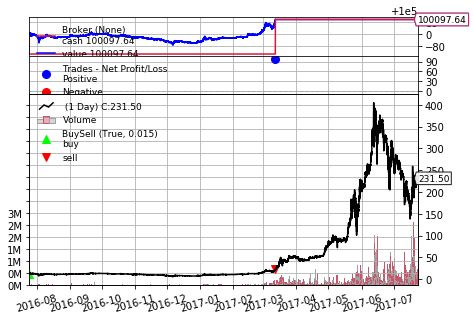

In [75]:
cerebro.plot(numfigs=1);

In [ ]:
btind.AroonUp?

In [ ]:
LinePlotterIndicator(close_over_sma, name='Close_over_SMA)